# Starter code

The code below trains a SoftMax regression model in PyTorch. It can easily be extended into a full multilayer neural network.

In [19]:
%matplotlib inline

In [20]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

import wandb

# Problem 1

In [ ]:
def matmul_loop(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br

    res = torch.zeros(ar, bc)
    for r in range(ar):
        for c in range(bc):
            for k in range(ac):
                res[r, c] += a[r, k] * b[k, c]

    return res

def matmul_einsum(a, b):
    return np.einsum('rk,kc->rc', a, b)
    # return np.einsum('rk,kc->rc', a, b, optimize='greedy')

def matmul_numpy(a, b):
    return np.matmul(a, b)

def matmul_torch_cpu(a, b):
    return torch.matmul(a, b)

def matmul_torch_cuda(a_cuda, b_cuda):
    return torch.matmul(a_cuda, b_cuda)
    # res = torch.matmul(a_cuda, b_cuda)
    # return res.cpu()

In [ ]:
def measure_time(matmul_fn, a, b, n=100):
    start = time.perf_counter()
    for _ in range(n):
        matmul_fn(a, b)
    end = time.perf_counter()
    return (end - start)


# functions = [matmul_loop, matmul_einsum, matmul_numpy, matmul_torch_cpu, matmul_torch_cuda]
# function_names = ['loop', 'einsum', 'numpy', 'torch_cpu', 'torch_cuda']
functions = [matmul_einsum, matmul_numpy, matmul_torch_cpu, matmul_torch_cuda]
function_names = ['einsum', 'numpy', 'torch_cpu', 'torch_cuda']
n = 50

a = np.random.randn(n, n).astype(np.float32)
b = np.random.randn(n, n).astype(np.float32)

a_torch = torch.from_numpy(a)
b_torch = torch.from_numpy(b)

a_cuda = a_torch
b_cuda = b_torch
a_cuda.to("cuda")
b_cuda.to("cuda")

# args = [(a, b), (a, b), (a, b), (a_torch, b_torch), (a_cuda, b_cuda)]
# loops = [2, 100000, 100000, 100000, 100000]
args = [(a, b), (a, b), (a_torch, b_torch), (a_cuda, b_cuda)]
loops = [10, 10, 10, 10]

for i, fn in enumerate(functions):
    _a, _b = args[i]
    t = measure_time(fn, _a, _b, n=loops[i])
    print(f'{function_names[i]}: {t:.4f} seconds for {loops[i]} iterations, giving {(t/loops[i]):.6f} per multiplication')

einsum: 0.0007 seconds for 10 iterations, giving 0.000067 per multiplication
numpy: 0.0053 seconds for 10 iterations, giving 0.000531 per multiplication
torch_cpu: 0.0074 seconds for 10 iterations, giving 0.000739 per multiplication
torch_cuda: 0.0001 seconds for 10 iterations, giving 0.000013 per multiplication


# MNIST

In [21]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

## Data loading

Training speed is important. By default, data is loaded on the CPU, then shipped in batches to the GPU. For this exercise, we will load the full dataset onto the GPU, which speeds up training.

In [23]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

```python
# Monkey-patch MNIST to use a more robust MNIST mirror
torchvision.datasets.MNIST.resources = [
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]
```

In [24]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\patry\AppData\Local\Temp\ipykernel_28584\2199848925.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs while solving the assignments.

In [25]:
def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    alpha_decay=0.0,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):
    init_alpha = alpha

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    #
    # for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros_like(_) for _ in model.parameters()]
    #
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #
            # alpha = init_alpha / (1 + alpha_decay + epoch)
            alpha = init_alpha * np.exp(-alpha_decay * epoch)

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            #
                            # TODO for Problem 2.3: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            # p.grad += TODO
                            #

                            p.grad += decay * p.data

                        #
                        # TODO for Problem 2.2: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        # alpha = TODO
                        #

                        #
                        # TODO for Problem 2.1: If needed, implement here a momentum schedule
                        # epsilon = TODO
                        #

                        #
                        # TODO for Problem 2.1: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        #
                        v[...] = (epsilon * v) + ((1 - epsilon) * p.grad)
                        # v.mul(epsilon).add((1-epsilon) * p.grad)

                        #
                        # TODO for Problem 2: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        #
                        p -= alpha * v
                        # p.sub_(alpha * v)

                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

# Problem 3

----------------------------------------------------------
After epoch 10 | valid err rate:  1.84% | doing  14 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 9)

-------------------------------------------
Test error rate: 1.900%, training took 26s.
-------------------------------------------


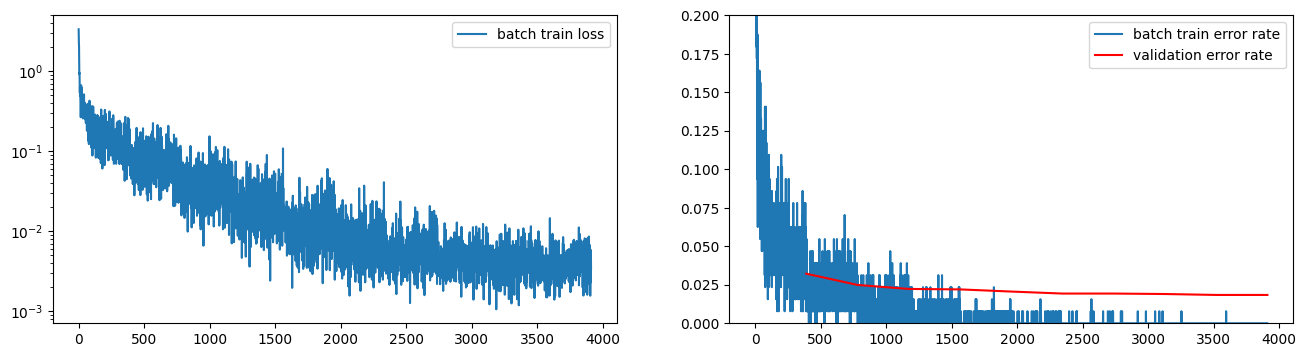

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

in_size = 28 * 28
model = Model(
    nn.Linear(in_size, in_size*4), nn.ReLU(),
    nn.Linear(in_size*4, in_size*2), nn.ReLU(),
    nn.Linear(in_size*2, in_size//2), nn.ReLU(),
    nn.Linear(in_size//2, 10)
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            # p.normal_(0, 0.5)
            nn.init.kaiming_normal_(p, mode="fan_in", nonlinearity="relu")
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model,
    mnist_loaders,
    alpha=0.1,
    # alpha_decay=0.01,
    epsilon=0.9,
    decay=0.0005,
    max_num_epochs=10,
    device="cuda"
)


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# Problem 4

----------------------------------------------------------
After epoch 10 | valid err rate:  1.10% | doing  14 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 9)

-------------------------------------------
Test error rate: 0.970%, training took 24s.
-------------------------------------------


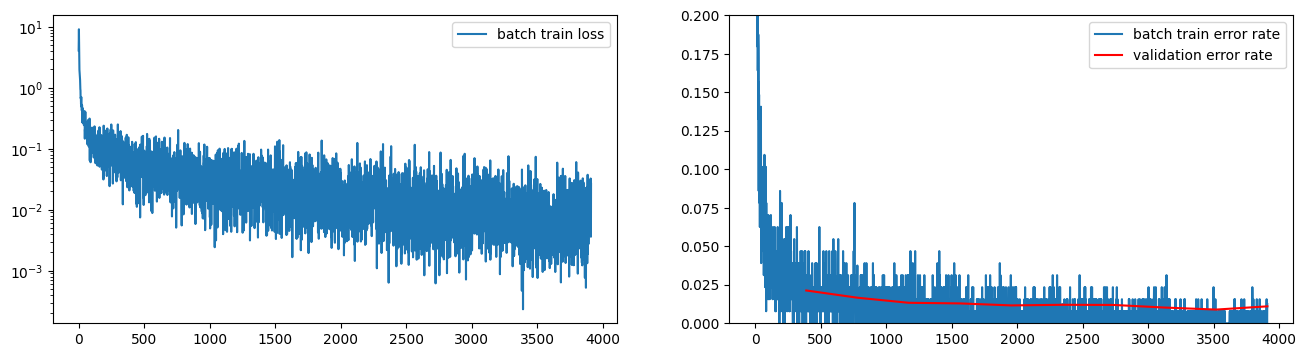

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        # X = X.view(X.size(0), -1)
        X = X.view(X.size(0), 1, 28, 28)    # batch size, n of channels, height, width
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 392),
    nn.ReLU(),
    nn.Linear(392, 10)
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            nn.init.kaiming_normal_(p, mode="fan_in", nonlinearity="relu")
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model,
    mnist_loaders,
    alpha=0.1,
    # alpha_decay=0.01,
    epsilon=0.9,
    decay=0.0005,
    max_num_epochs=10,
    device="cuda"
)


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# Problem 5

## Rand transform data

In [9]:
# Previous data transformation

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\patry\AppData\Local\Temp\ipykernel_28584\2199848925.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Learn on rand transformed

In [ ]:
# New data transformation

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split


train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # random rotation (-15 to +15 degrees)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # random shifts (10% of image size)
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # normalize MNIST mean/std
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # normalize MNIST mean/std
])


# load dataset
train_dataset = MNIST(root="./data", train=True, transform=train_transform, download=True)
test_dataset = MNIST(root="./data", train=False, transform=test_transform, download=True)

# split train dataset into training and validation
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# create dataLoaders
mnist_loaders = {
    "train": DataLoader(train_dataset, batch_size=64, shuffle=True),
    "valid": DataLoader(valid_dataset, batch_size=64, shuffle=False),
    "test": DataLoader(test_dataset, batch_size=64, shuffle=False),
}

----------------------------------------------------------
After epoch 10 | valid err rate:  1.50% | doing  16 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 10)

--------------------------------------------
Test error rate: 0.670%, training took 214s.
--------------------------------------------


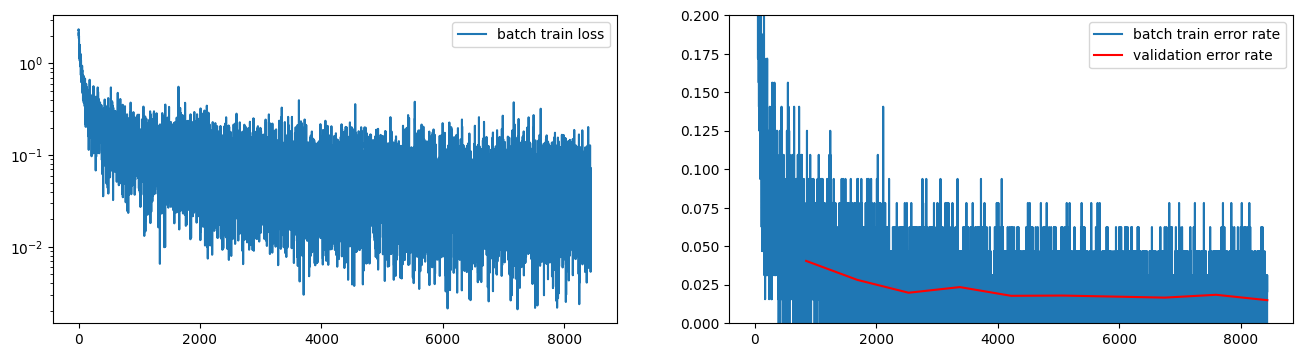

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        # X = X.view(X.size(0), -1)
        X = X.view(X.size(0), 1, 28, 28)    # batch size, n of channels, height, width
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 392),
    nn.ReLU(),
    nn.Linear(392, 10)
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            nn.init.kaiming_normal_(p, mode="fan_in", nonlinearity="relu")
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model,
    mnist_loaders,
    alpha=0.1,
    # alpha_decay=0.01,
    epsilon=0.9,
    decay=0.0005,
    max_num_epochs=10,
    device="cuda"
)


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# Problem 6

----------------------------------------------------------
After epoch 16 | valid err rate:  1.73% | doing  16 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 10)

--------------------------------------------
Test error rate: 0.970%, training took 500s.
--------------------------------------------


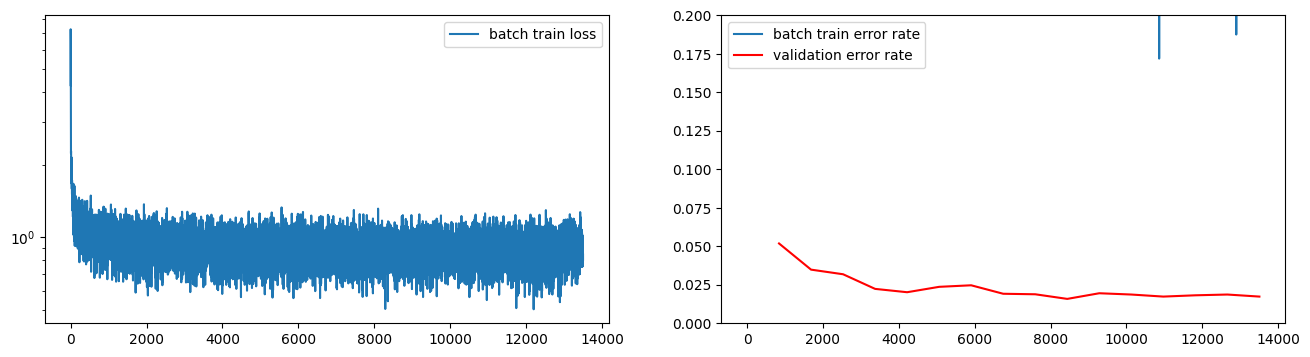

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        # X = X.view(X.size(0), -1)
        X = X.view(X.size(0), 1, 28, 28)    # batch size, n of channels, height, width
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 392),
    nn.ReLU(),
    nn.Linear(392, 10),
    nn.Dropout(p=0.5)
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            nn.init.kaiming_normal_(p, mode="fan_in", nonlinearity="relu")
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

model.train()

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model,
    mnist_loaders,
    alpha=0.1,
    # alpha_decay=0.01,
    epsilon=0.9,
    decay=0.0005,
    max_num_epochs=20,
    device="cuda"
)

model.eval()

test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# Problem 7

In [14]:
# https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/

class CustomBatchNorm2d(nn.Module):
    def __init__(self, num_features, momentum=0.9, epsilon=1e-5):
        super(CustomBatchNorm2d, self).__init__()
        self.num_features = num_features
        self.momentum = momentum
        self.epsilon = epsilon

        # Learnable parameters (scale and shift)
        self.gamma = nn.Parameter(torch.ones(num_features))  # Scale
        self.beta = nn.Parameter(torch.zeros(num_features))  # Shift

        # Running statistics (used for inference)
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, X):
        if self.training:
            # Compute batch mean and variance
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = X.var(dim=(0, 2, 3), keepdim=True, unbiased=False)

            # Update running statistics for inference
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean.squeeze()
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var.squeeze()
        else:
            # Use stored running mean and variance during inference
            mean = self.running_mean.view(1, -1, 1, 1)
            var = self.running_var.view(1, -1, 1, 1)

        # Normalize
        X_norm = (X - mean) / torch.sqrt(var + self.epsilon)

        # Scale and shift
        return self.gamma.view(1, -1, 1, 1) * X_norm + self.beta.view(1, -1, 1, 1)


----------------------------------------------------------
After epoch 10 | valid err rate:  1.01% | doing  16 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 10)

--------------------------------------------
Test error rate: 0.960%, training took 618s.
--------------------------------------------


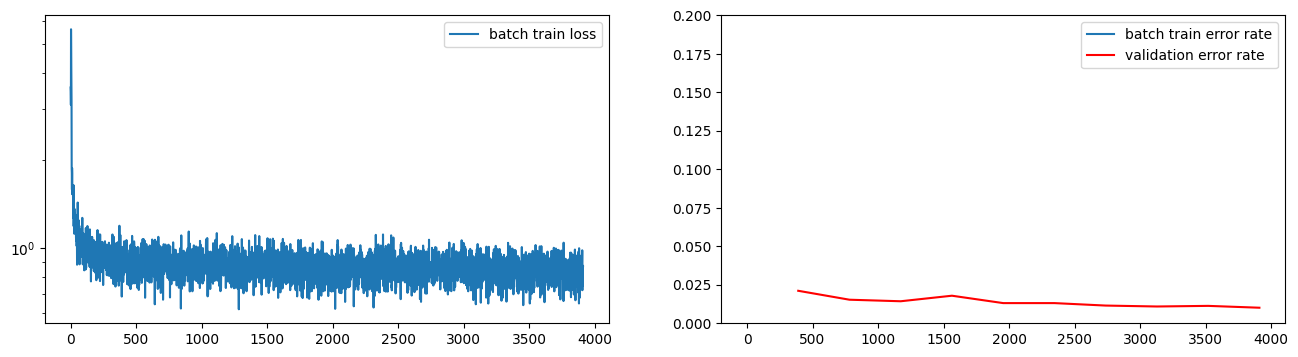

In [15]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        # X = X.view(X.size(0), -1)
        X = X.view(X.size(0), 1, 28, 28)    # batch size, n of channels, height, width
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Conv2d(1, 32, kernel_size=3, padding=1), CustomBatchNorm2d(32), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), CustomBatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 392), nn.ReLU(),
    nn.Linear(392, 10),
    nn.Dropout(p=0.5)
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name and p.dim() >= 2:
            nn.init.kaiming_normal_(p, mode="fan_in", nonlinearity="relu")
        elif "bias" in name:
            p.zero_()
        elif "gamma" in name:
            p.data.fill_(1)
        elif "beta" in name:
            p.data.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)


model.train()

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model,
    mnist_loaders,
    alpha=0.1,
    # alpha_decay=0.01,
    epsilon=0.9,
    decay=0.0005,
    max_num_epochs=10,
    device="cpu"
)

model.eval()

test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# Problem 8

In [17]:
def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    alpha_decay=0.0,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):
    init_alpha = alpha

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    #
    # for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros_like(_) for _ in model.parameters()]
    #
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            
            # alpha = init_alpha / (1 + alpha_decay + epoch)
            alpha = init_alpha * np.exp(-alpha_decay * epoch)

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            norm_threshold = 1.0

                            row_norms = torch.norm(p, dim=1, keepdim=True)  # Compute row norms
                            scaling_factors = torch.clamp(norm_threshold / (row_norms + 1e-6), max=1.0)
                            p *= scaling_factors  # Scale down rows exceeding threshold

                        v[...] = (epsilon * v) + ((1 - epsilon) * p.grad)
                        p -= alpha * v



                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

----------------------------------------------------------
After epoch 10 | valid err rate:  1.00% | doing  16 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 10)

--------------------------------------------
Test error rate: 0.890%, training took 614s.
--------------------------------------------


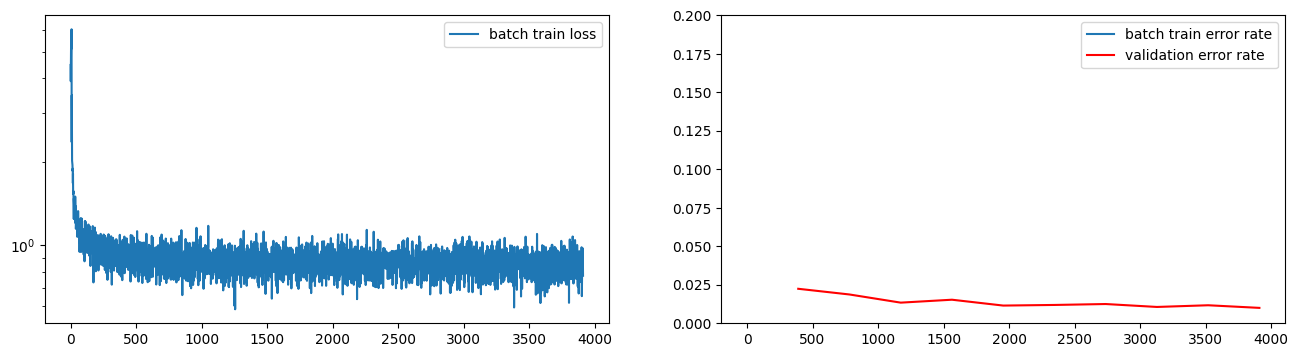

In [18]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        # X = X.view(X.size(0), -1)
        X = X.view(X.size(0), 1, 28, 28)    # batch size, n of channels, height, width
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Conv2d(1, 32, kernel_size=3, padding=1), CustomBatchNorm2d(32), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), CustomBatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 392), nn.ReLU(),
    nn.Linear(392, 10),
    nn.Dropout(p=0.5)
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name and p.dim() >= 2:
            nn.init.kaiming_normal_(p, mode="fan_in", nonlinearity="relu")
        elif "bias" in name:
            p.zero_()
        elif "gamma" in name:
            p.data.fill_(1)
        elif "beta" in name:
            p.data.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)


model.train()

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model,
    mnist_loaders,
    alpha=0.1,
    # alpha_decay=0.01,
    epsilon=0.9,
    decay=0.0005,
    max_num_epochs=10,
    device="cpu"
)

model.eval()

test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# Problem 9

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

In [ ]:
import random

def random_search_tuner(
    param_ranges, 
    num_trials=20, 
    max_epochs=10, 
    device="cpu"
):
    best_params = None
    best_val_err = float("inf")

    for trial in range(num_trials):
        # randomly sample hyperparameters
        hyperparams = {
            "learning_rate": random.uniform(*param_ranges["learning_rate"]),
            "epsilon": random.uniform(*param_ranges["epsilon"]),
            "decay": random.uniform(*param_ranges["decay"]),
        }

        print(f"Trial {trial+1}/{num_trials} - Hyperparameters: {hyperparams}")

        model = Model(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 392),
            nn.ReLU(),
            nn.Linear(392, 10)
        )

        with torch.no_grad():
            for name, p in model.named_parameters():
                if "weight" in name:
                    nn.init.kaiming_normal_(p, mode="fan_in", nonlinearity="relu")
                elif "bias" in name:
                    p.zero_()
                else:
                    raise ValueError('Unknown parameter name "%s"' % name)

        t_start = time.time()
        SGD(model,
            mnist_loaders,
            alpha=hyperparams["learning_rate"],
            epsilon=0.9,
            decay=0.0005,
            max_num_epochs=max_epochs,
            device=device
        )

        test_err_rate = compute_error_rate(model, mnist_loaders["test"])
        m = (
            f"Test error rate: {test_err_rate * 100.0:.3f}%, "
            f"training took {time.time() - t_start:.0f}s."
        )
        print("{0}\n{1}\n{0}".format("-" * len(m), m))

        # update best parameters if this model is better
        if test_err_rate < best_val_err:
            best_val_err = test_err_rate
            best_params = hyperparams

        print(f"Trial {trial+1} completed - Validation Error: {test_err_rate:.4f}")

    print("\nBest Hyperparameters Found:", best_params)
    print("\nBest Validation Error Rate:", best_val_err)
    return best_params


----------------------------------------------------------
After epoch  3 | valid err rate:  1.59% | doing   5 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 3)

-------------------------------------------
Test error rate: 1.580%, training took 91s.
-------------------------------------------
Trial 5 completed - Validation Error: 0.0158

Best Hyperparameters Found: {'learning_rate': 0.04781171331208023, 'epsilon': 0.5508877776291122, 'decay': 0.0014719774243840524}


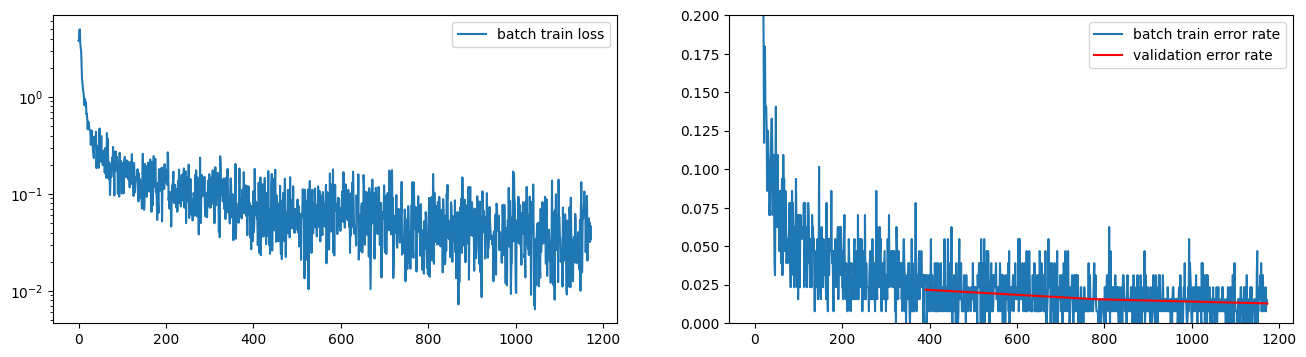

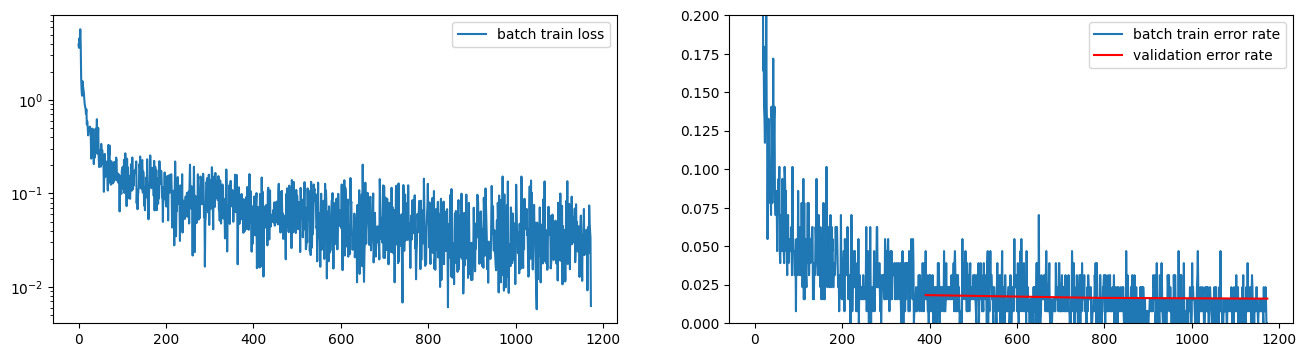

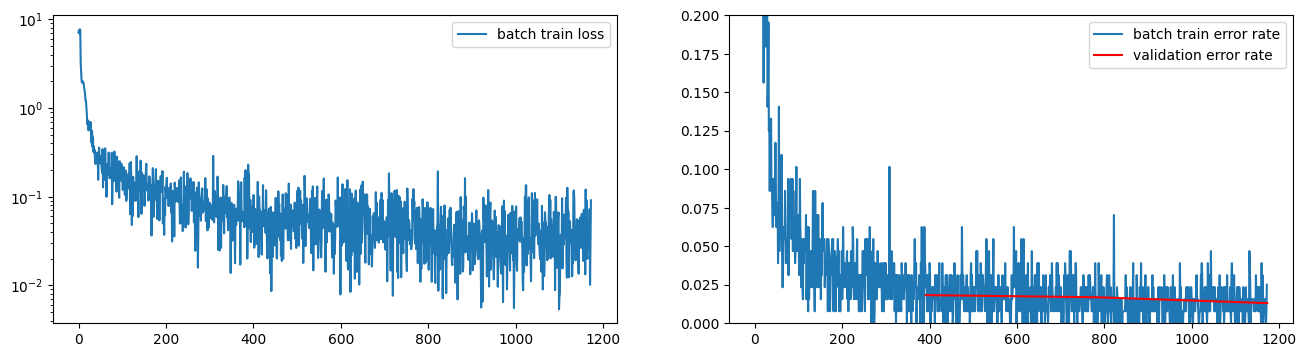

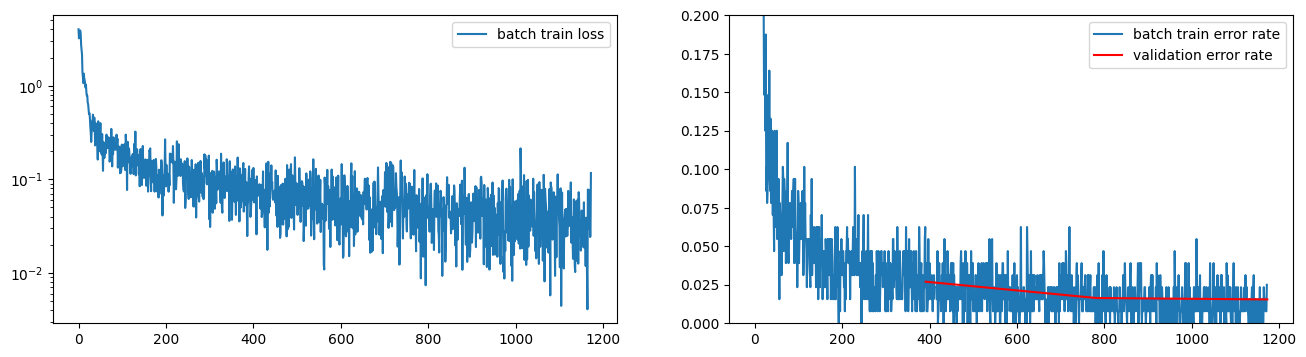

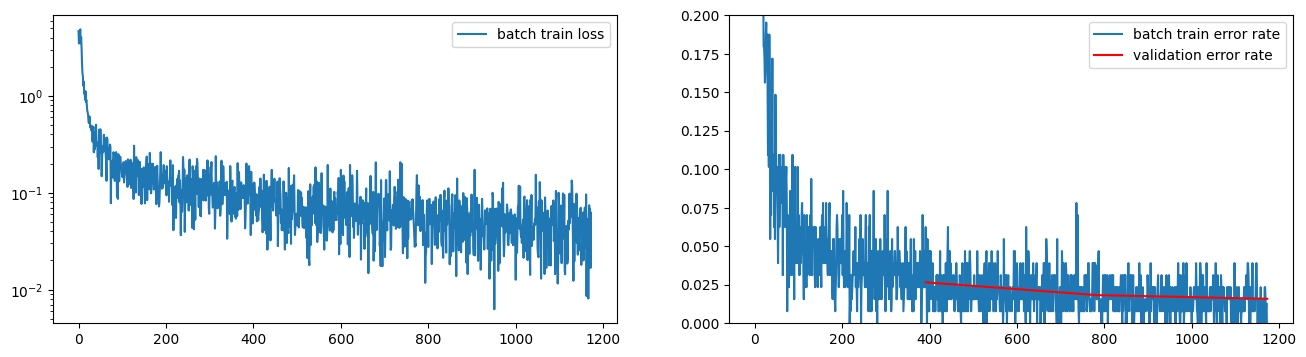

In [38]:
param_ranges = {
    "learning_rate": (1e-5, 1e-1),
    "epsilon": (0.0, 1.0),
    "decay": (0.0, 0.1),
}

best_hyperparams = random_search_tuner(
    param_ranges, 
    num_trials=5, 
    max_epochs=3, 
    device="cpu"
)
